In [69]:
import os
import numpy as np
import random
import torch
import time
from pathlib import Path
from DQN.train_dqn import train_dqn
import mlflow
from envs.GraphEnv.impnode import ImpnodeEnv
from torch.utils.tensorboard import SummaryWriter
from DQN import DQN_agent_modular
from DQN.test_and_compare import test_loop
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [70]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('train_baseline_models_dw_nd')

<Experiment: artifact_location='file:///C:/rituja_git/ma-rituja-pardhi/mlruns/28', creation_time=1715420824230, experiment_id='28', last_update_time=1715420824230, lifecycle_stage='active', name='train_baseline_models_dw_nd', tags={}>

In [71]:
seed = 412
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms(True,warn_only=True)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [72]:
def train(results_base_path_train, g_type, train_data_path, val_data_path, depth, hidden_1, hidden_2):
    seed = 412
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms(True,warn_only=True)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    with mlflow.start_run(run_name='t-{}'.format(g_type)):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        results_base_path_train = results_base_path_train+"/{}".format(g_type)
        
        timestamp = time.strftime("%Y%m%d%H%M%S")
        new_directory = f"{results_base_path_train}_{timestamp}"
        os.makedirs(new_directory)
        results_base_path_train = new_directory
        print(f"Directory already exists. Created a new one: {new_directory}")
            
        params = {
        'device': device,
        'seed': seed, 
        
        'num_train_eps' :7000,
        'num_mem_fill_eps' :100, 
        'discount' :0.99, 
        'batch_size' :64,
        'mem_capacity' :500000, 
        'update_frequency' :1000, 
        'eps_max' :1.0,
        'eps_min' :0.05, 
        'eps_step' :5000, 
        'lr' :0.0001,
        'alpha' :0.001,
            
        'gnn_depth':depth,
        'state_size':2,
        'hidden_size1':hidden_1,
        'hidden_size2':hidden_2,
        'action_size':1,
        'n_step':5,
            
        'g_type': g_type,
        'num_nodes' :(30, 50),
        'anc' :'dw_nd',
        'max_removed_nodes':None,
            
        'train_data_path':train_data_path,
        'val_data_path':val_data_path,   
        'val_step':1000,
        
        'results_base_path_train': results_base_path_train
        }
        mlflow.log_params(params)
        
        writer = SummaryWriter(results_base_path_train+'/tensorboard/{}_{}'.format(g_type,timestamp))
        print(params['anc'])
        env_train = ImpnodeEnv(anc=params['anc'], 
                       g_type=g_type, 
                       num_nodes=params['num_nodes'], 
                       mode='train',
                       data_path=params['train_data_path']
                       )
        
        dqn_agent_train = DQN_agent_modular.DQNAgent(device,
                                             alpha=params['alpha'],
                                             gnn_depth=params['gnn_depth'],
                                             state_size=params['state_size'],
                                             hidden_size1=params['hidden_size1'],
                                             hidden_size2=params['hidden_size2'],
                                             action_size=params['action_size'],
                                             discount=params['discount'],
                                             eps_max=params['eps_max'],
                                             eps_min=params['eps_min'],
                                             eps_step=params['eps_step'],
                                             memory_capacity=params['mem_capacity'],
                                             lr=params['lr'],
                                             mode='train')
        
        train_dqn(env_train, dqn_agent_train, results_base_path_train, params['num_train_eps'], params['num_mem_fill_eps'], params['n_step'], params['batch_size'], params['update_frequency'] ,train_data_path=params['train_data_path'], val_data_path=params['val_data_path'], val_step=params['val_step'], writer=writer)
        
        subdir = 'data/real/Cost'
        file_name = 'Crime_degree.gml'
        data_path = Path.cwd()/subdir
        
        env_test = ImpnodeEnv(anc='dw_nd', data_path=data_path,mode='test',  file_name=file_name)
        actions, reward_history, ep_score_history = test_loop(env=env_test,
                                                        agent=dqn_agent_train,
                                                        NUM_TEST_EPS = 1)
                                                       
        mlflow.log_metric('anc_crime',ep_score_history[0])
    

In [73]:
train_data_types = ['barabasi-albert']#,'erdos-renyi','watts-strogatz']
train_data_paths = [None]#, None, None]
val_data_paths = ['data/synthetic_small_dataset/BA_val_30_50']#'data/synthetic_small_dataset/ER_val_30_50','data/synthetic_small_dataset/WS_val_30_50']
results_base_path_train = 'results/train_baseline_model_dw_nd'

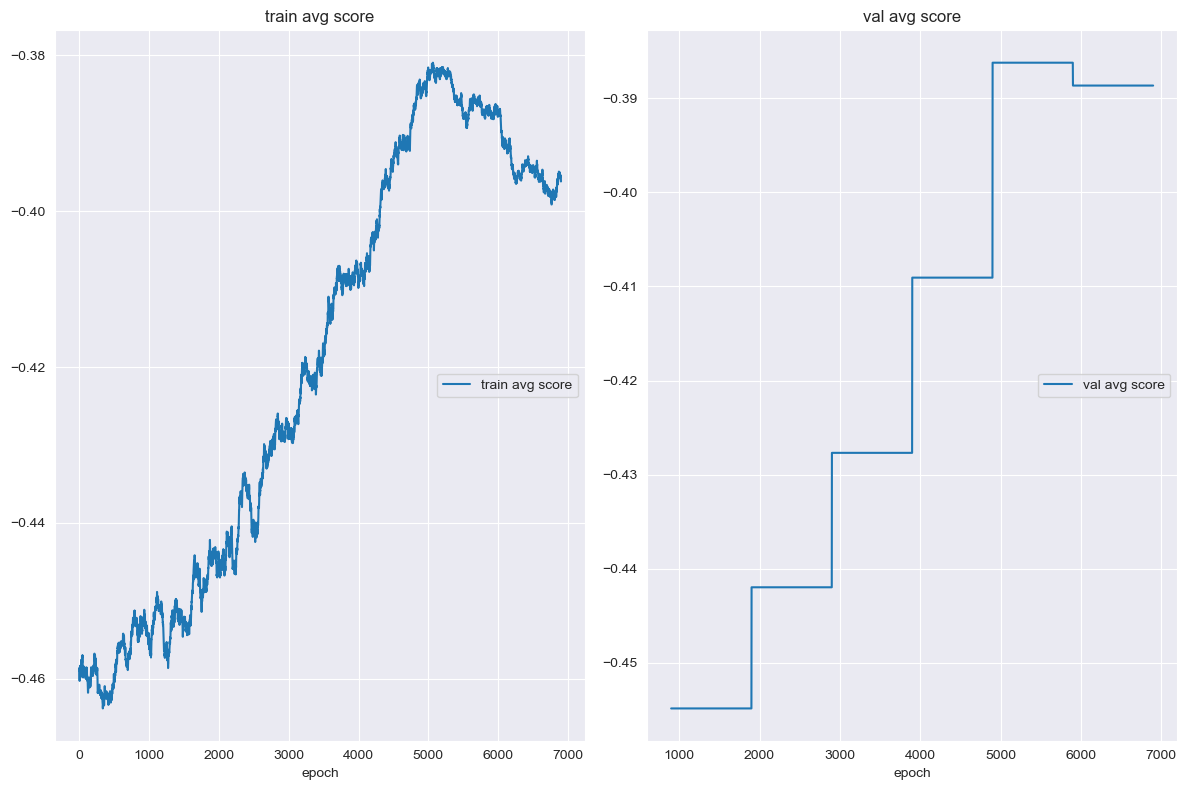

In [74]:
for train_data, train_data_path, val_data_path in zip(train_data_types, train_data_paths, val_data_paths):
    gnn_depth = [2]
    hidden_size1 = [4,8]
    hidden_size2 = [4,8]
    for depth in gnn_depth:
        for hidden_1 in hidden_size1:
            for hidden_2 in hidden_size2:
                train(results_base_path_train, g_type=train_data,train_data_path = train_data_path, val_data_path = Path.cwd()/val_data_path, depth=depth, hidden_1=hidden_1, hidden_2=hidden_2)